In [33]:
%matplotlib inline
%pdb
#import time
#tstart = time.time()

Automatic pdb calling has been turned ON


In [34]:
import numpy as np
from astropy.io import fits
from astropy.table import Table
from matplotlib import pyplot as plt
import snhostspec as wfirst
from glob import glob

In [63]:
reload(wfirst)
sim = wfirst.WfirstSimData()
sim.add_all_snana_simdata()
sim.load_matchdata()
sim.pick_random_matches()
sim.load_sed_data()
sim.generate_all_seds()

Initiliazed an empty WfirstSimData object
Adding SNANA sim data from SNANA.SIM.OUTPUT/IMG_2T_4FILT_MD_SLT3_Z08_Ia-01_HEAD.FITS
Loading observed galaxy data from the 3DHST catalogs
Finding observed galaxies that ~match simulated SN host
galaxy properties (redshift and magnitude)...
Loading data for best-fit SEDs from 3DHST fits to observed photometry for all galaxies in all five CANDELS fields...
Using Gabe Brammer's EAZY code to generate the best-fit SEDs of the observed galaxies that we have matched up to the SNANA simulation hostgal data.


snhostspec.py:387: RuntimeWarning: divide by zero encountered in double_scalars
  import eazy.igm
snhostspec.py:388: RuntimeWarning: invalid value encountered in multiply
  igmz = eazy.igm.Inoue14().full_IGM(z, templz)


In [70]:
sim.write_catalog("wfirst_snhostspec_master.cat")

Wrote sim data catalog to wfirst_snhostspec_master.cat


In [109]:
sim2.simdata['sedoutfile'][0]

'3DHST/sedsim.output/wfirst_simsed.GOODS-S.0364.dat'

In [120]:
reload(wfirst)
sim2 = wfirst.WfirstSimData()
sim2.load_simdata_catalog('wfirst_snhostspec_master.cat')
idsubset = sim2.get_host_percentile_indices()
sim2.simulate_subaru_snr_curves(np.ravel(idsubset))

Initiliazed an empty WfirstSimData object
Running the PFS ETC for UDS.27830 at z 0.78 with mag 23.39for 1 hrs, sedfile 3DHST/sedsim.output/wfirst_simsed.UDS.27830.dat.
 output: etcout/subaruPFS_SNR_UDS.27830_z0.78_m23.39_1hrs.dat
Finished in 210.9 seconds
Running the PFS ETC for UDS.27830 at z 0.78 with mag 23.39for 5 hrs, sedfile 3DHST/sedsim.output/wfirst_simsed.UDS.27830.dat.
 output: etcout/subaruPFS_SNR_UDS.27830_z0.78_m23.39_5hrs.dat
Finished in 221.6 seconds
Running the PFS ETC for UDS.27830 at z 0.78 with mag 23.39for 10 hrs, sedfile 3DHST/sedsim.output/wfirst_simsed.UDS.27830.dat.
 output: etcout/subaruPFS_SNR_UDS.27830_z0.78_m23.39_10hrs.dat
Finished in 231.7 seconds
Running the PFS ETC for COSMOS.27241 at z 0.82 with mag 23.82for 1 hrs, sedfile 3DHST/sedsim.output/wfirst_simsed.COSMOS.27241.dat.
 output: etcout/subaruPFS_SNR_COSMOS.27241_z0.82_m23.82_1hrs.dat
Finished in 232.4 seconds
Running the PFS ETC for COSMOS.27241 at z 0.82 with mag 23.82for 5 hrs, sedfile 3DHST/sedsi

In [121]:
len(idsubset)

5

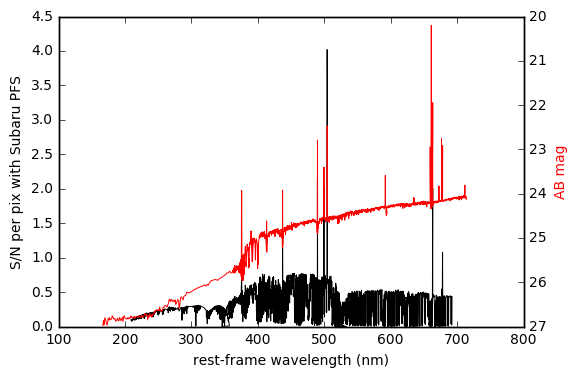

In [152]:
reload(wfirst)
snrspec = wfirst.SubaruObsSim('etcout/subaruPFS_SNR_COSMOS.27241_z0.82_m23.82_10hrs.dat')
snrspec.verbose=2
snrspec.plot(marker=' ', frame='rest', showspec=True, ls='-', lw=0.7)

Redshift detected with S/N=7.2 at rest wave=504 nm


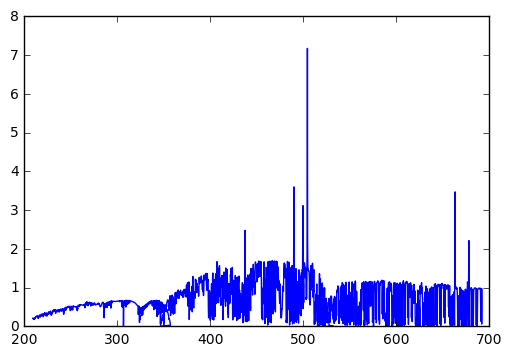

In [153]:
snrspec.check_redshift(snrthresh=4, showplot=True)

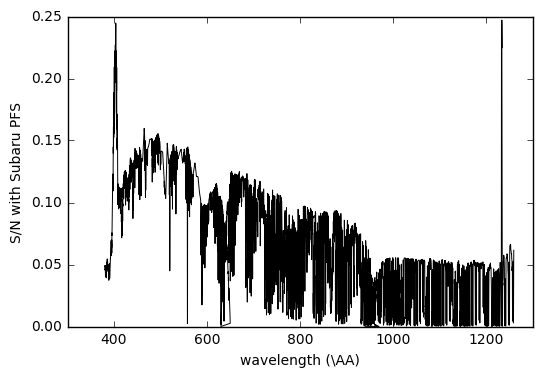

In [124]:
ax = plt.gca()
ax.plot(snrspec.wave, snrspec.signaltonoise, 'k-', ls='-', lw=0.7)
xlabel = ax.set_xlabel('wavelength ($\AA$)')
ylabel = ax.set_ylabel('S/N with Subaru PFS')

In [7]:
mastercat = wfirst.WfirstMasterHostCatalog()
mastercat.load_all_simdata()
mastercat.write('wfirst_snhostspec_master.cat')

In [13]:
mastercat2 = wfirst.WfirstMasterHostCatalog()
mastercat2.read('wfirst_snhostspec_master.cat')

In [21]:
mastercat2.mastercat = ascii.read('wfirst_snhostspec_master.cat', format='commented_header')

In [23]:
mastercat2.simulate_all_seds()

In [ ]:
reload(wfirst)
sim = wfirst.WfirstSimData('SNANA.SIM.OUTPUT/IMG_2T_4FILT_MD_SLT3_Z08_Ia-01_HEAD.FITS')
sim.load_matchdata('3DHST/3dhst_master.phot.v4.1.cat.FITS')
sim.get_matchlists()
sim.simdata.write("wfirst_snhostgal_sim.dat", format='ascii.commented_header')

Read in the simulated SN data from the SNANA sim data files.
Each SNANA simulation has generated a HEAD.FITS file that contains a binary table with metadata for each simulated SN and host galaxy.  The high-z host galaxy magnitudes have been drawn from distributions that match the CANDELS+CLASH sample -- so there is some selection bias built in, but it will be similar to the selection biases of the WFIRST SN survey (?). 

In [ ]:
reload(wfirst)

In [ ]:
%pwd

In [ ]:
sim.snanadata.read?

In [ ]:
simlist = []
simfilelist_med = glob('SNANA.SIM.OUTPUT/*Z08*HEAD.FITS')
simfilelist_deep = glob('SNANA.SIM.OUTPUT/*Z17*HEAD.FITS')
hostz_med, hostmag_med = np.array([]), np.array([])
for simfile in simfilelist_med:
    sim = wfirst.WfirstSimData(simfile)
    sim.load_matchdata('3DHST/3dhst_master.phot.v4.1.cat.FITS')
    sim.get_matchlists()
    hostz_med = np.append(hostz_med, sim.zsim)
    hostmag_med = np.append(hostmag_med, sim.mag)
    simlist.append(sim)

hostz_deep, hostmag_deep = np.array([]), np.array([])
for simfile in simfilelist_deep:
    sim = wfirst.WfirstSimData(simfile)
    sim.load_matchdata('3DHST/3dhst_master.phot.v4.1.cat.FITS')
    sim.get_matchlists()
    hostz_deep = np.append(hostz_deep, sim.zsim)
    hostmag_deep = np.append(hostmag_deep, sim.mag)
    simlist.append(sim)    

Now for each SNANA sim file, load in the catalog of galaxy SED data from 3DHST and use EAZY to simulate an SED.  The output simulated SEDs are stored in the sub-directory '3dHST/sedsim.output'

In [ ]:
if not os.path.isdir('3DHST/sedsim.output'):
    os.mkdir('3DHST/sedsim.output')
for sim in simlist:
    sim.load_sed_data()
    sim.simulate_seds()

TODO NEXT : run the Subaru ETC on each simulated galaxy spectrum and determine the S/N achieved after 1 hour 5 hour, 10 hour exposures

In [ ]:
# Example of a spectrum plot
eazyspecsim = wfirst.EazySpecSim('3DHST/sedsim.output/wfirst_simsed.AEGIS.0185.dat')
eazyspecsim.plot()

In [ ]:
photdat3d = fits.open('3DHST/3dhst_master.phot.v4.1/3dhst_master.phot.v4.1.cat.FITS')
f160 = photdat3d[1].data['f_F160W']
zspec = photdat3d[1].data['z_spec']
zphot = photdat3d[1].data['z_peak']
zbest = np.where(zspec>0, zspec, zphot)
usephot = photdat3d[1].data['use_phot']

ivalid = np.where(((f160>0) & (zbest>0)) & (usephot==1) )[0]
mH3D = -2.5*np.log10(f160[ivalid])+25
z3D = zbest[ivalid]
plt.plot(z3D, mH3D, 'b.', ls=' ', ms=1, alpha=0.1)
#plt.plot(hostz_med, hostmag_med, 'g.', ls=' ', ms=3, alpha=0.3)
plt.plot(hostz_deep, hostmag_deep, 'r.', ls=' ', ms=3, alpha=0.3)
ax = plt.gca()
xlim = ax.set_xlim(0,2.5)
ylim = ax.set_ylim(28,20)
ax.set_xlabel('redshift')
ax.set_ylabel('host galaxy AB magnitude')

In [ ]:
ztestlist = [0.8,1.2,1.5,2.0,2.5]
for ztest in ztestlist:
    inear = np.where(np.abs(hostz_deep-ztest)<0.05)[0]
    magnear = hostmag_deep[inear]
    print("{:3.1f} {:4.1f} {:4.1f} {:4.1f}".format(
            ztest, magnear.min(), np.median(magnear), magnear.max()))

In [ ]:
sim1701.load_matchdata('3DHST/3dhst_master.phot.v4.1/3dhst_master.phot.v4.1.cat.FITS')
sim1701.get_matchlists(dz=0.02, dH=0.2)

In [ ]:
sim1701.matchdata.columns

In [ ]:
fieldid = sim1701.matchid[0]
fieldstr, idxstr = fieldid.split('.')
field = fieldstr.lower().replace('-','')
idx = int(idxstr)
print(field)
print(idx)
print(sim1701.matchid[0])

Generate a simulated host galaxy spectrum with EAZY 

In [ ]:
templz, tempmag = wfirst.simulate_eazy_sed(sim1701.matchid[0], savetofile='wfirst_simsed.dat')

TODO: run the ETC on the simulated spectrum

from the command line we would do: 

  python ~/src/subarupfsETC/run_etc.py @wfirst_subarupfs_etc.defaults

Read in the ETC output

In [ ]:
reload(wfirst)
etcdat = wfirst.SubaruSpecSim('etcout/ref.snc.dat')

In [ ]:
plt.plot(etcdat.wave, etcdat.signaltonoise,'k-', marker=' ')

In [ ]:
tfinish = time.time()
print('{:.3e} sec elapsed'.format(tfinish-tstart))

In [ ]:
fitsfilename = glob('3DHST/goodss_3dhst.*.eazypy.data.fits')[0]
hdu = fits.open(fitsfilename)
hdu.readall()
hdu.close()
hdu['ID'].data

In [ ]:
print len(templz)
print len(tempmag)
plt.plot(templz, tempmag, color='k', marker=' ', ls='-', lw=1)
ax = plt.gca()
ax.set_xlim(300,2100)
ax.set_ylim(30, 20)
print(templz.min())
print(templz.max())
print(tempmag.max())
print(tempmag.min())

In [ ]:
print('{:.1f} {:.1f} {:.1f} {:.1f} '.format(np.min(sim1701.nmatch),
        np.mean(sim1701.nmatch), np.median(sim1701.nmatch),
        np.std(sim1701.nmatch)))
plt.hist(sim1701.nmatch, bins=50)

In [ ]:
np.random.shuffle?

Read in the simulated SN data from the SNANA sim data files.
Each SNANA simulation has generated a HEAD.FITS file that contains a binary table with metadata for each simulated SN and host galaxy.  The high-z host galaxy magnitudes have been drawn from distributions that match the CANDELS+CLASH sample -- so there is some selection bias built in, but it will be similar to the selection biases of the WFIRST SN survey (?). 

The data we want to extract from the head.fits files are:  
#COL  LABEL
1 SNID
9 SNTYPE
22 HOSTGAL_PHOTOZ
23 HOSTGAL_PHOTOZ_ERR
24 HOSTGAL_SPECZ
25 HOSTGAL_SPECZ_ERR
27 HOSTGAL_LOGMASS
28 HOSTGAL_LOGMASS_ERR
XX HOSTGAL_MAG_R
XX HOSTGAL_MAG_Y 
XX HOSTGAL_MAG_J
XX HOSTGAL_MAG_H
XX HOSTGAL_MAG_F
49 SIM_REDSHIFT_HOST

In [ ]:
snanasimhead = fits.open(
    'SNANA.SIM.OUTPUT/IMG_2T_4FILT_MD_SLT3_Z17_Ia-01_HEAD.FITS')
zsim = snanasimhead[1].data['SIM_REDSHIFT_HOST']
hostmagH = snanasimhead[1].data['HOSTGAL_MAG_H']
fig = plt.figure(1)
ax1 = fig.add_subplot(111)
ax1.plot(zsim, hostmagH, marker='.', ls=' ', color='r')

From the 3DHST catalog, we extract redshift and H band mag for the actual galaxies in the 3DHST fields.  Below is an overlay plot showing both the SN sample and the 3DHST sample.

In [ ]:
photdat3d = fits.open('3DHST/3dhst_master.phot.v4.1/3dhst_master.phot.v4.1.cat.FITS')
f160 = photdat3d[1].data['f_F160W']
zspec = photdat3d[1].data['z_spec']
zphot = photdat3d[1].data['z_peak']
zbest = np.where(zspec>0, zspec, zphot)
usephot = photdat3d[1].data['use_phot']

ivalid = np.where(((f160>0) & (zbest>0)) & (usephot==1) )[0]
mH3D = -2.5*np.log10(f160[ivalid])+25
z3D = zbest[ivalid]
plt.plot(z3D, mH3D, 'b.', ls=' ', ms=1, alpha=0.1)
plt.plot(zsim, hostmagH, 'r.', ls=' ', ms=3, alpha=0.5)

#photdat3d[1].header